In [1]:
import pandas as pd
import torch as th
import torch.nn as nn
import glob
import pickle

import sys
sys.path.append('../models/')
from models.lstm import LSTM
from models.transformer import Transformer
from models.train_model import RPS_loss, train_model

In [2]:
training_home_teams_matches = th.load("dataset/tensors/training_home_teams_matches.pt")
training_away_teams_matches = th.load("dataset/tensors/training_away_teams_matches.pt")
training_matches_features_home = th.load("dataset/tensors/training_matches_features_home.pt")
training_matches_features_away = th.load("dataset/tensors/training_matches_features_away.pt")
training_targets = th.load("dataset/tensors/training_targets.pt")

test_home_teams_matches = th.load("dataset/tensors/test_home_teams_matches.pt")
test_away_teams_matches = th.load("dataset/tensors/test_away_teams_matches.pt")
test_matches_features_home = th.load("dataset/tensors/test_matches_features_home.pt")
test_matches_features_away = th.load("dataset/tensors/test_matches_features_away.pt")
test_targets = th.load("dataset/tensors/test_targets.pt")



In [3]:
import pickle
file1 = 'dataset/tensors/idx_to_teams.pkl'
file2 = 'dataset/tensors/teams_to_idx.pkl'
file3 = 'dataset/tensors/result_map.pkl'

with open(file1, 'rb') as file:
    idx_to_teams = pickle.load(file)

with open(file2, 'rb') as file:
    teams_to_idx = pickle.load(file)

with open(file3, 'rb') as file:
    result_map = pickle.load(file)

print(result_map)
idx_to_result = {0: 'H', 1: 'D', 2: 'A'}



{'H': 0, 'D': 1, 'A': 2}


In [4]:
print("Training data")
print(training_home_teams_matches.shape) # the idex of home team for the matches
print(training_away_teams_matches.shape) # the idex of away team for the matches
print(training_matches_features_home.shape) # the features of the home team for the matches
print(training_matches_features_away.shape) # the features of the away team for the matches
print(training_targets.shape) # the targets of the matches H D A

print("Test data")
print(test_home_teams_matches.shape)
print(test_away_teams_matches.shape)
print(test_matches_features_home.shape)
print(test_matches_features_away.shape)
print(test_targets.shape)




Training data
torch.Size([24843])
torch.Size([24843])
torch.Size([24843, 5, 14])
torch.Size([24843, 5, 14])
torch.Size([24843])
Test data
torch.Size([3072])
torch.Size([3072])
torch.Size([3072, 5, 14])
torch.Size([3072, 5, 14])
torch.Size([3072])


In [5]:
import torch.nn.functional as F

def one_hot_targets(targets):
    num_classes = th.max(targets).item() + 1
    return F.one_hot(targets, num_classes=num_classes).type(th.float32)

training_targets_oh = one_hot_targets(training_targets)
test_targets_oh = one_hot_targets(test_targets)

print(training_targets_oh.shape)
print(test_targets_oh.shape)

for i in range(3):
    print(training_targets_oh[i])
    print(test_targets_oh[i])

torch.Size([24843, 3])
torch.Size([3072, 3])
tensor([0., 1., 0.])
tensor([0., 0., 1.])
tensor([1., 0., 0.])
tensor([0., 1., 0.])
tensor([0., 0., 1.])
tensor([1., 0., 0.])


In [6]:
index = 0
print("First match")
print("Home team: ", idx_to_teams[training_home_teams_matches[index].item()])
print("Away team: ", idx_to_teams[training_away_teams_matches[index].item()])
print("Features home: ", training_matches_features_home[index])
print("Features away: ", training_matches_features_away[index])
# print("Target: ", idx_to_result[training_targets[index].item()])


First match
Home team:  Bourg Peronnas
Away team:  Laval
Features home:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  2.7000,  2.8800,  2.9000],
        [-1.1730, -1.8492, -0.8932, -0.3694,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  2.2500,  3.0000,  3.5000],
        [-0.6845,  1.3282, -1.1527,  0.8992,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  2.4000,  3.0000,  3.2000],
        [-0.2291,  1.8941, -1.4227,  0.5266,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  3.1000,  3.1000,  2.3800],
        [ 0.2685,  1.2267, -1.1430, -0.6323,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  2.1000,  3.1000,  3.7500]])
Features away:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  2.2000,  3.0000,  3.6000],
        [-0.3644, -0.6365, -0.8932, -1.1

In [7]:
#split the data into training and validation
from torch.utils.data import DataLoader, TensorDataset

split = 0.8
split_idx = int(len(training_home_teams_matches) * split)

train_dataset = TensorDataset(training_home_teams_matches[:split_idx], training_away_teams_matches[:split_idx], training_matches_features_home[:split_idx], training_matches_features_away[:split_idx], training_targets_oh[:split_idx])
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # true could cause lookahead

val_dataset = TensorDataset(training_home_teams_matches[split_idx:], training_away_teams_matches[split_idx:], training_matches_features_home[split_idx:], training_matches_features_away[split_idx:], training_targets_oh[split_idx:])
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(test_home_teams_matches, test_away_teams_matches, test_matches_features_home, test_matches_features_away, test_targets_oh)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Training data")
print(len(train_dataset))
# print(len(train_loader))

print("Validation data")
print(len(val_dataset))
# print(len(val_loader))

print("Test data")
print(len(test_dataset))
# print(len(test_loader))

Training data
19874
Validation data
4969
Test data
3072


In [8]:
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # true could cause lookahead
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
for home_teams, away_teams, home_features, away_features, targets in train_loader:
    print(home_teams.shape)
    print(away_teams.shape)
    print(home_features.shape)
    print(away_features.shape)
    print(targets.shape)
    break

torch.Size([100])
torch.Size([100])
torch.Size([100, 5, 14])
torch.Size([100, 5, 14])
torch.Size([100, 3])


50 Loss: 1.1399999856948853 Train Acc: 29.29145728643216 Val Acc: 29.72
100 Loss: 1.2200000286102295 Train Acc: 29.29145728643216 Val Acc: 29.72
150 Loss: 0.9899999499320984 Train Acc: 29.29145728643216 Val Acc: 29.72
200 Loss: 1.090000033378601 Train Acc: 29.29145728643216 Val Acc: 29.72
250 Loss: 1.090000033378601 Train Acc: 29.29145728643216 Val Acc: 29.72
300 Loss: 1.2200000286102295 Train Acc: 29.29145728643216 Val Acc: 29.72
350 Loss: 0.9599999785423279 Train Acc: 29.29145728643216 Val Acc: 29.72
400 Loss: 1.1799999475479126 Train Acc: 29.29145728643216 Val Acc: 29.72
450 Loss: 1.2200000286102295 Train Acc: 29.29145728643216 Val Acc: 29.72
500 Loss: 1.0499999523162842 Train Acc: 29.29145728643216 Val Acc: 29.72
550 Loss: 1.0199999809265137 Train Acc: 29.29145728643216 Val Acc: 29.72
600 Loss: 1.1899999380111694 Train Acc: 29.29145728643216 Val Acc: 29.72
650 Loss: 1.159999966621399 Train Acc: 29.29145728643216 Val Acc: 29.72
700 Loss: 1.100000023841858 Train Acc: 29.2914572864321

KeyboardInterrupt: 

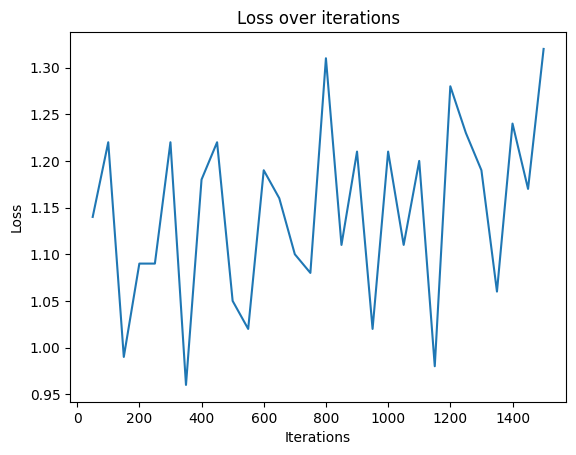

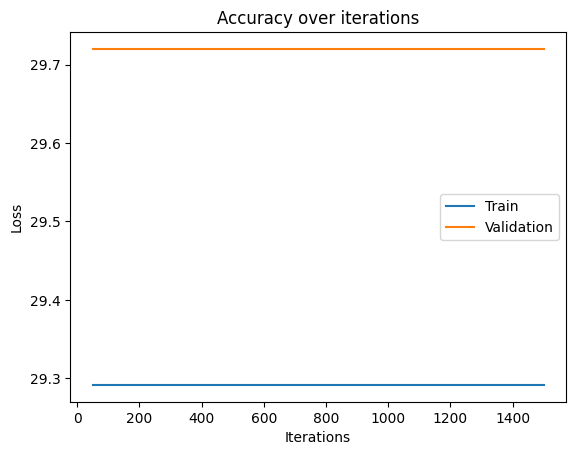

In [11]:
model_lstm = LSTM(
            num_features=14,
            inception_depth=2, 
            inception_out=24, 
            hidden_size=500, 
            num_heads=1, num_classes=3, bottleneck_dim = None)

train_model(model_lstm, 
criterion=RPS_loss(),
# criterion= nn.CrossEntropyLoss(),
train_loader=train_loader, 
val_loader=val_loader,
learning_rate=0.01,
num_epochs=10)

RuntimeError: The size of tensor a (3072) must match the size of tensor b (192) at non-singleton dimension 2

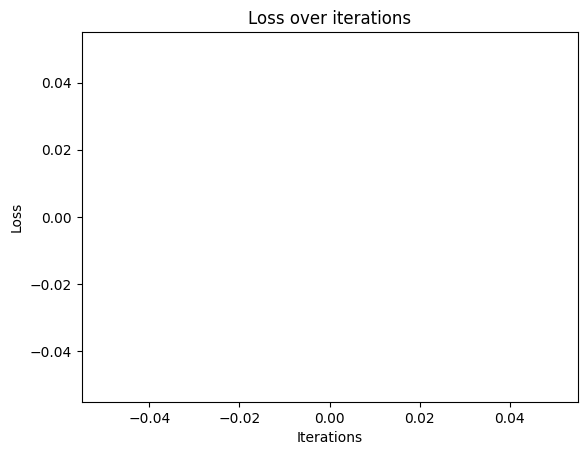

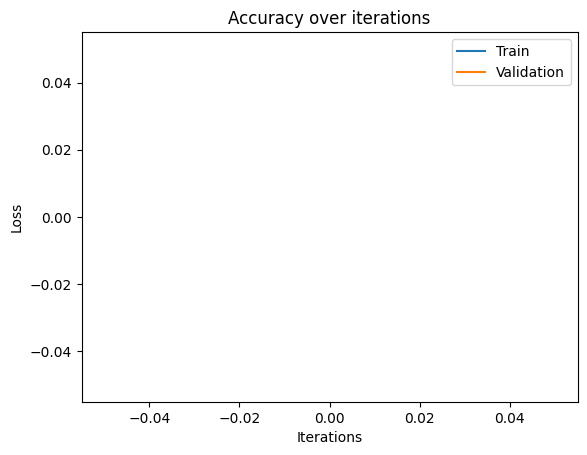

In [15]:
# in_channels = 14  # this should be the number of features in each data sample
# # the remaining inputs are hyperparameters which can be tuned accordingly


model_transformer = Transformer(
            num_features=14,
            inception_depth=2, 
            inception_out=24,
            num_heads=8,
            num_layers=6,
            d_ff = 256,
            d_h = 512,
            max_timespan = 50,
            dropout = 0.1)

train_model(model_transformer, 
# criterion=RPS_loss(),
criterion= nn.CrossEntropyLoss(ignore_index=0),
train_loader=train_loader, 
val_loader=val_loader,
learning_rate=0.1,
num_epochs=10)